In [3]:
# import libraries
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import pymc3 as pm3
#import numdifftools as ndt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

Ref: https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f

We will generate data that follows a normally distributed errors around a ground truth function:

In [41]:
# generate data
N = 1000
x = np.linspace(0,20,N)
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = 4*x + ϵ
df = pd.DataFrame({'y':y, 'x':x})
df['constant'] = 1

In [42]:
df

,y,x,constant
0,2.781854,0.00000,1
1,-6.634253,0.02002,1
2,-2.354072,0.04004,1
3,-1.507308,0.06006,1
4,-0.317706,0.08008,1
...,...,...,...
995,78.615401,19.91992,1
996,80.539903,19.93994,1
997,77.688546,19.95996,1
998,78.190526,19.97998,1


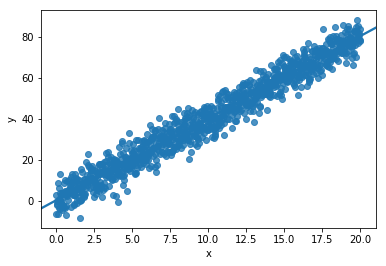

In [43]:
# plot
sns.regplot(df.x, df.y);

#### Modelling with OLS Package with Statsmodels

Since we created regression-like, continuous data, we will use sm.OLS to calculate the best coefficients and Log-likelihood (LL) as a benchmark.

In [44]:
# split features and target
X = df[['constant', 'x']]

# fit model and summarize
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 2.183e+04
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:12:15   Log-Likelihood:                -3017.5
No. Observations:                1000   AIC:                             6039.
Df Residuals:                     998   BIC:                             6049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.1863      0.313      0.596      0.552      -0.428       0.800
x              4.0026      0.027    147.759      0.000       3.949       4.056
==============================================================================
Omnibus:                        0.896   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.639   Jarque-Bera (JB):                0.962
Skew:                          -0.068   Prob(JB):                        0.618
Kurtosis:                       2.930   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice constant is close to zero, and beta for feature x is close to 4, per the ground truth generator we used.


#### Maximum Likelihood Estimate Approach

+ From here, we’ll use a combination of packages and custom functions to see if we can calculate the same OLS results above using MLE methods.


+ Because scipy.optimize has only a minimize method, we'll minimize the negative of the log-likelihood. This is even what they recommend! Math trickery is often faster and easier than re-inventing the wheel!


+ We can build a simple function that does everything in one pass for regression outputs:

Ref : https://www.youtube.com/results?search_query=mathematicalmonk

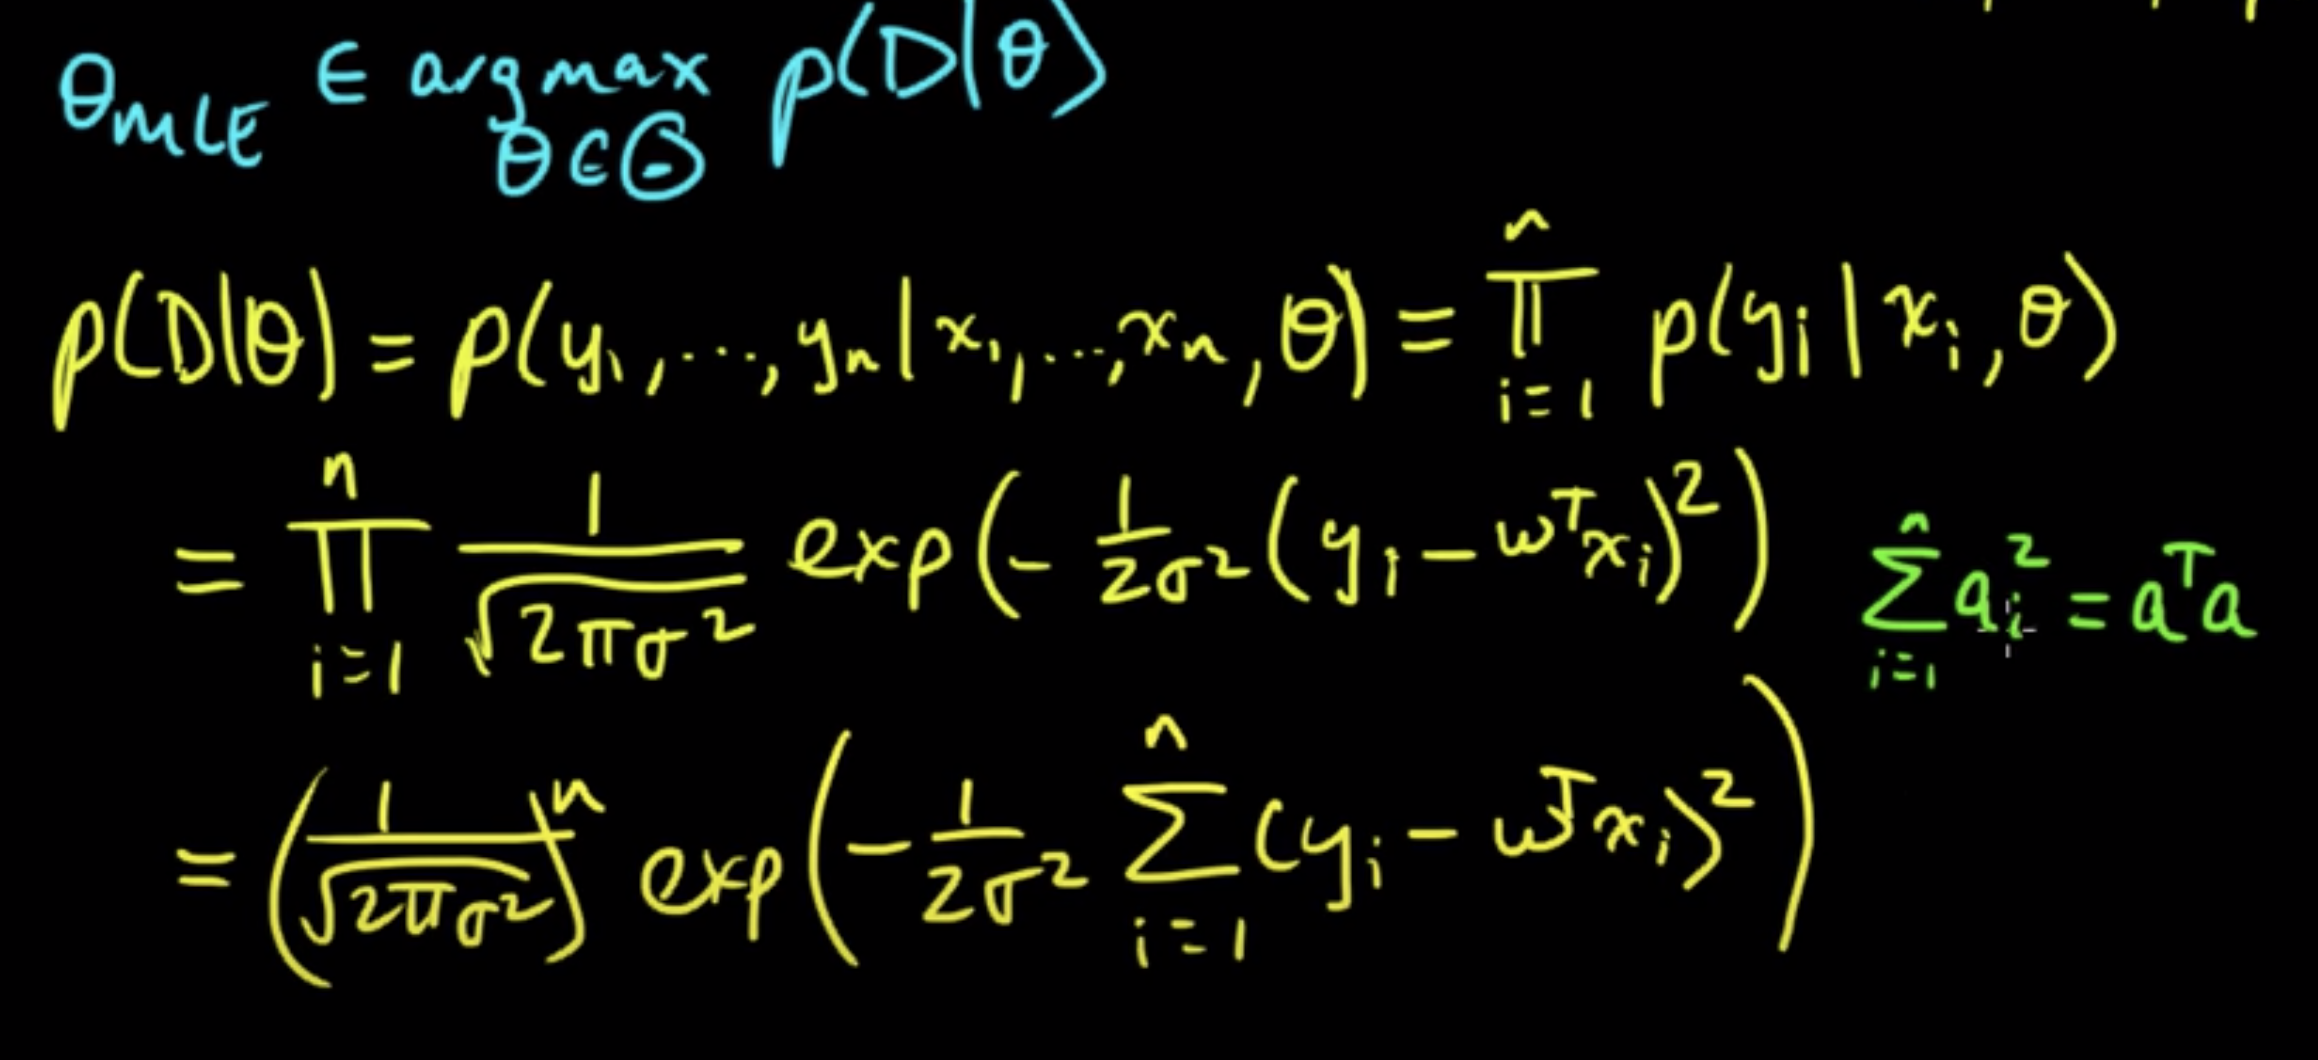

In [45]:
# define likelihood function
def MLERegression(params):
    
    intercept, beta, sd = params[0], params[1], params[2]
    
    #inputs are guesses at our parameters
    yhat = intercept + beta*x # predictions
    
    # compute PDF of observed values normally distributed around mean (yhat)with a standard deviation of sd
    negLL = -np.sum(stats.norm.logpdf(y, loc=yhat, scale=sd))
    
    #return negative LL
    return(negLL)

Now that we have a cost function, let’s initialize and minimize it:

In [47]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = minimize(MLERegression, guess, method = 'Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: 3017.457393
         Iterations: 112
         Function evaluations: 200


In [48]:
results

 final_simplex: (array([[0.18632858, 4.002592  , 4.94570294],
       [0.18625416, 4.00259944, 4.94570152],
       [0.18638476, 4.00259429, 4.94569889],
       [0.1863489 , 4.00259133, 4.94574113]]), array([3017.45739275, 3017.45739275, 3017.45739279, 3017.4573928 ]))
           fun: 3017.457392748561
       message: 'Optimization terminated successfully.'
          nfev: 200
           nit: 112
        status: 0
       success: True
             x: array([0.18632858, 4.002592  , 4.94570294])

In [50]:
# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']   
# np.round(resultsdf.head(2), 4)

In [51]:
resultsdf

,coef
constant,0.186329
x,4.002592
sigma,4.945703


+ MLE is consistent with OLS.
+ With infinite data, it will estimate the optimal β, and approximate it well for small but robust datasets.
+ MLE is efficient; no consistent estimator has lower asymptotic mean squared error than MLE.